In [1]:
# Basics Importation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# For Detailed Stats Output
import statsmodels.api as sm
# The linear regression models 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoCV, ElasticNetCV
# Instantiating the linear regression models
ols = LinearRegression()
ridge = Ridge()
lasso  = Lasso()
lassocv = LassoCV()
elasticnet = ElasticNet()
elasticnetcv = ElasticNetCV()
# The tree model
from sklearn import tree
# Instantiating the tree model (regression type)
regressor = tree.DecisionTreeRegressor()
# The ensemble model for random forest and bagging
from sklearn import ensemble
# Instantiating the ensemble models
randomForest = ensemble.RandomForestRegressor()
bagging = ensemble.BaggingRegressor()
# Instantiating the boost models
gbm = ensemble.GradientBoostingRegressor()
abr = ensemble.AdaBoostRegressor()
# xg boost
import xgboost as xgb
# lg boost
import lightgbm as lgb
# K mean clustering
from sklearn.cluster import KMeans
kmeans = KMeans()
# The model selection for cross validation, k fold splits, train_test_split, grid search etc. 
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Some automatic feature selection functions (recursive finding, best feature selection etc.)
import sklearn.feature_selection as fs
# Importing the different error evaluation/metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score
# Importing PCA
from sklearn.decomposition import PCA
# Making it so that we can see all columns of the dataframe
pd.set_option('display.max_columns', None)

# Import data
df=pd.read_csv('standardized_dummified_df_total_neighborhood_interact.csv', index_col='Id')
df_test=pd.read_csv('standardized_dummified_df_test_neighborhood_interact.csv', index_col='Id')
x=df[~df.SalePrice.isnull()].drop(['SalePrice'],axis=1)
y=df[~df.SalePrice.isnull()].SalePrice
kaggle_test=df_test
# df_test must have (1459) rows

In [2]:
def undummify(dataframe):
    tot_col=dataframe.columns
    cat_col=list(tot_col[tot_col.str.contains('__')])
    cat_col_split=set(map(lambda x:x.split('__')[0],cat_col))
    cat_dict={}
    for col in cat_col_split:
        sub_df=dataframe[cat_col].loc[:,list(map(lambda x:col in x, dataframe[cat_col].columns))]
        for i in sub_df.columns:
            label_num=int(i.split('__')[1])
            sub_df.loc[:,i]=np.array(sub_df.loc[:,i])*label_num
        cat_dict[col]=sub_df.sum(axis=1)+1
    df1=dataframe.drop(cat_col,axis=1)
    df2=pd.DataFrame(cat_dict)
    return pd.concat([df1,df2],axis=1)

In [3]:
def important_coefs_lasso(model, dataframe,returnlist):
    '''
    - A function that returns non-zero coefficients in order from a lasso model output
    ---------------
    - dataframe: dataframe of model inputs
    - model: model object
    '''
    lassoCoef = pd.Series(model.coef_, index=dataframe.columns)
    if returnlist=='Pos': 
        lassoCoef=lassoCoef[np.abs(lassoCoef)>0]
        return lassoCoef.sort_values(ascending=False)
    elif returnlist=='Zero':
        lassoCoef=lassoCoef[np.abs(lassoCoef)<=1e-5]
        return lassoCoef.sort_values(ascending=False)
    else: 
        return lassoCoef.sort_values(ascending=False)

In [4]:
def sort_ridge_coefs(model, dataframe):
    ridge_coef = pd.Series(model.coef_, index=dataframe.columns)
    ridge_coef.sort_values(ascending=False)
    order = abs(ridge_coef).sort_values(ascending=False)
    return ridge_coef[order.index]

In [5]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)

### Lasso

In [35]:
# Initial Lasso
# trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)
alphaRange = np.linspace(10e-6,0.05,100)
grid_param=[{'alpha': alphaRange}]
para_search = GridSearchCV(estimator=Lasso(max_iter=5000),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
para_search.fit(trainX, trainY)
lasso_best_score = para_search.best_score_
lasso_best_alpha = para_search.best_params_['alpha']
lasso.set_params(alpha=lasso_best_alpha, normalize = False)
lasso.fit(trainX,trainY)

l_MSE = np.mean((lasso.predict(testX)-testY)**2)
l_RMSE_in_dollars = np.mean((np.exp(lasso.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(l_MSE))
print('Test RMSE in $$: %s' %(l_RMSE_in_dollars))


Test MSE: 0.013889691925191692
Test RMSE in $$: 21796.020413295882


In [36]:
########################################################
########################################################
######## Predict Kaggle ################################
para_search.fit(x,y)
one_lasso_predict_for_test=para_search.predict(x) # <----- for ensemble coefficient optimization
one_lasso_predict=para_search.predict(kaggle_test)
######## Predict Kaggle ################################
########################################################
########################################################

In [37]:
# Remove Worst Features for Lasso right away
lasso_worst_feat=important_coefs_lasso(lasso, trainX,'Zero')
lasso_df=trainX.copy()
lasso_df_test=testX.copy()
lasso_df.drop(lasso_worst_feat.index,axis=1,inplace=True)
lasso_df_test.drop(lasso_worst_feat.index,axis=1,inplace=True)
l_para_search=GridSearchCV(estimator=Lasso(max_iter=5000,tol=0.007),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
l_para_search.fit(lasso_df,trainY)
l_lasso_score=-l_para_search.score(lasso_df,trainY)
l_lasso_test_score=-l_para_search.score(lasso_df_test,testY)
l_RMSE_in_dollars=np.mean((np.exp(-l_para_search.predict(lasso_df_test))-np.exp(testY))**2)**0.5
print('train MSE: %s' %(l_lasso_score))
print('test MSE: %s' %(l_lasso_test_score))
print('Test RMSE in $$: %s' %(l_RMSE_in_dollars))


train MSE: 0.00953771906483897
test MSE: 0.014498706330672175
Test RMSE in $$: 199622.3627689352


In [38]:
########################################################
########################################################
######## Predict Kaggle ################################
# Perform same feature change on kaggle test
lasso_fit_df=x.drop(lasso_worst_feat.index,axis=1)
l_para_search.fit(lasso_fit_df,y)
lasso_kaggle_test=kaggle_test.drop(lasso_worst_feat.index,axis=1)
two_lasso_predict_for_test=l_para_search.predict(lasso_fit_df) # <----- for ensemble coefficient optimization
two_lasso_predict=l_para_search.predict(lasso_kaggle_test)
######## Predict Kaggle ################################
########################################################
########################################################

In [39]:
# lasso_best_feat=important_coefs_lasso(lasso, trainX,'All')
# lasso_best_feat=abs(lasso_best_feat)
# lasso_best_feat=lasso_best_feat.sort_values(ascending=False)
# lasso_best_feat=list(lasso_best_feat.index)

In [40]:
# # Recursive Lasso
# recursive_lasso_score=[]
# recursive_lasso_test_score=[]
# i=0
# lasso_df=trainX.copy()
# lasso_df_test=testX.copy()
# for col in lasso_best_feat[-1:-101:-1]:
#     i+=1
#     lasso_df.drop(col,axis=1,inplace=True)
#     lasso_df_test.drop(col,axis=1,inplace=True)
#     recursive_para_search=GridSearchCV(estimator=Lasso(max_iter=5000,tol=0.007),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
#     recursive_para_search.fit(lasso_df,trainY)
#     recursive_lasso_score.append(recursive_para_search.score(lasso_df,trainY))
#     recursive_lasso_test_score.append(recursive_para_search.score(lasso_df_test,testY))
#     print(i,'/',np.array(lasso_best_feat[-1:-101:-1]).shape[0],end='\r')

In [41]:
# plt.figure()
# plt.plot(np.array(recursive_lasso_score)*-1,c='red', label='training error')
# plt.plot(np.array(recursive_lasso_test_score)*-1,c='blue', label='test error')
# plt.ylabel('MSE')
# plt.xlabel('Features Taken Out')
# plt.legend()
# plt.show()

In [42]:
lasso_best_feat=important_coefs_lasso(lasso, trainX,'All')
lasso_best_feat=abs(lasso_best_feat)
lasso_best_feat=lasso_best_feat.sort_values(ascending=False)
lasso_best_feat=list(lasso_best_feat.index)

In [14]:
# Recursive linear regression
ols_score=[]
ols_test_score=[]
i=0
ols_df=trainX.copy()
ols_df_test=testX.copy()
for col in lasso_best_feat[-1:-201:-1]:
    i+=1
    ols_df.drop(col,axis=1,inplace=True)
    ols_df_test.drop(col,axis=1,inplace=True)
    ols.fit(ols_df,trainY)
    ols_score.append(metrics.mean_squared_error(trainY, ols.predict(ols_df)))
    ols_test_score.append(metrics.mean_squared_error(testY, ols.predict(ols_df_test)))
    print(i,'/',np.array(lasso_best_feat[-1:-201:-1]).shape[0],end='\r')


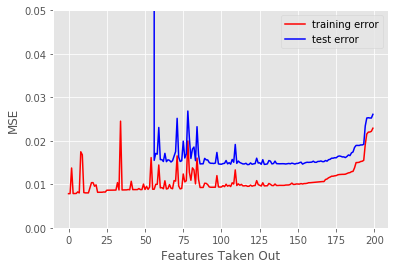

In [15]:
plt.figure()
plt.ylim([0,0.05])
plt.plot(np.array(ols_score),c='red', label='training error')
plt.plot(np.array(ols_test_score),c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Features Taken Out')
plt.legend()
plt.show()

In [43]:
########################################################
########################################################
######## Predict Kaggle ################################
# we see that mse begins rise up
ols_df=pd.concat([trainX.copy(),testX.copy()],axis=0,sort=False)
totalY=pd.concat([trainY,testY],axis=0,sort=False)

ols.fit(ols_df[lasso_best_feat[0:-150]],totalY)
ols_predict_for_test=ols.predict(ols_df[lasso_best_feat[0:-150]]) # <----- for ensemble coefficient optimization
ols_predict=ols.predict(kaggle_test[lasso_best_feat[0:-150]])
######## Predict Kaggle ################################
########################################################
########################################################

### Ridge

In [17]:
# Initial Ridge
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.3, random_state=0)
r_alphaRange = np.linspace(10e-3,100,100)
r_grid_param=[{'alpha': r_alphaRange}]
r_para_search = GridSearchCV(estimator=Ridge(max_iter=5000),param_grid=r_grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
r_para_search.fit(trainX, trainY)

ridge_best_score = r_para_search.best_score_
ridge_best_alpha = r_para_search.best_params_['alpha']
ridge.set_params(alpha=ridge_best_alpha, normalize = False)
ridge.fit(trainX,trainY)

r_MSE = np.mean((ridge.predict(testX)-testY)**2)
r_RMSE_in_dollars = np.mean((np.exp(ridge.predict(testX))-np.exp(testY))**2)**0.5
print('Test MSE: %s' %(r_MSE))
print('Test RMSE in $$: %s' %(r_RMSE_in_dollars))

Test MSE: 0.014030501297486274
Test RMSE in $$: 22031.781903296756


In [18]:
ridge_best_feat=sort_ridge_coefs(ridge, trainX).index
# Recursive ridge
recursive_ridge_score=[]
recursive_ridge_test_score=[]
i=0
ridge_df=trainX.copy()
ridge_df_test=testX.copy()
for col in ridge_best_feat[-1:-101:-1]:
    i+=1
    ridge_df.drop(col,axis=1,inplace=True)
    ridge_df_test.drop(col,axis=1,inplace=True)
    recursive_r_para_search=GridSearchCV(estimator=Ridge(max_iter=5000),param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    recursive_r_para_search.fit(ridge_df,trainY)
    recursive_ridge_score.append(recursive_r_para_search.score(ridge_df,trainY))
    recursive_ridge_test_score.append(recursive_r_para_search.score(ridge_df_test,testY))
    print(i,'/',np.array(ridge_best_feat[-1:-101:-1]).shape[0],end='\r')

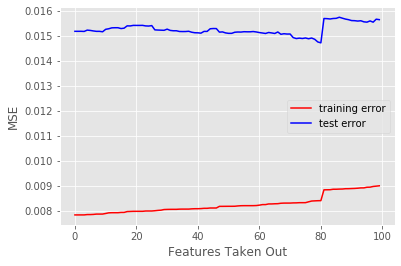

In [19]:
plt.figure()
plt.plot(np.array(recursive_ridge_score)*-1,c='red', label='training error')
plt.plot(np.array(recursive_ridge_test_score)*-1,c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Features Taken Out')
plt.legend()
plt.show()

In [44]:
########################################################
########################################################
######## Predict Kaggle ################################
# we see that mse begins rise up
ridge_df=pd.concat([trainX.copy(),testX.copy()],axis=0,sort=False)
totalY=pd.concat([trainY,testY],axis=0,sort=False)

recursive_r_para_search.fit(ridge_df[ridge_best_feat[0:-78]],totalY) 
ridge_predict_for_test=recursive_r_para_search.predict(ridge_df[ridge_best_feat[0:-78]]) # <----- for ensemble coefficient optimization
ridge_predict=recursive_r_para_search.predict(kaggle_test[ridge_best_feat[0:-78]])
######## Predict Kaggle ################################
########################################################
########################################################

### Random Forest

In [21]:
# Initial Forest
param_grid = {
    'max_depth' : range(5,20),\
    'max_features': range(5,20)
}
randomForest = ensemble.RandomForestRegressor()
grid_search_forest = GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
                                                                 min_samples_leaf=2,min_samples_split=2,\
                                                                 bootstrap=True,oob_score = True,n_jobs=-1),\
                                  param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
%time grid_search_forest.fit(trainX, trainY)

# Print results    
print('MSE Score on test data set (using best parameters): {0:.3f}'.format(-grid_search_forest.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_forest.predict(testX))-np.exp(testY))**2)**0.5))

CPU times: user 8.65 s, sys: 412 ms, total: 9.06 s
Wall time: 1min 26s
MSE Score on test data set (using best parameters): 0.019
RMSE in $$ on test data set (using best parameters): 30797.4


In [22]:
randomForest.set_params(n_estimators=100,criterion="mse",bootstrap=True,oob_score = False,n_jobs=-1,random_state=0,\
                       max_depth=grid_search_forest.best_params_['max_depth'],max_features=grid_search_forest.best_params_['max_features'],\
                       min_samples_leaf=2,min_samples_split=2)
randomForest.fit(trainX,trainY)
forest_best_feat=pd.Series(randomForest.feature_importances_,index=trainX.columns)
forest_best_feat.sort_values(ascending=False,inplace=True)
forest_best_feat=list(forest_best_feat.index)

In [23]:
# Recursive forest
recursive_forest_score=[]
recursive_forest_test_score=[]
i=0
forest_df=trainX.copy()
forest_df_test=testX.copy()
listremoval_forest=forest_best_feat.copy()
for reduction in range(6):
    i+=1
    removelist=listremoval_forest[-30:-1]
    for item in removelist:
        listremoval_forest.remove(item)
    forest_df.drop(removelist,axis=1,inplace=True)
    forest_df_test.drop(removelist,axis=1,inplace=True)
    recursive_f_para_search=GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
                                                                 min_samples_leaf=2,min_samples_split=2,\
                                                                 bootstrap=True,oob_score = True,n_jobs=-1),\
                                  param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
    recursive_f_para_search.fit(forest_df,trainY)
    recursive_forest_score.append(recursive_f_para_search.score(forest_df,trainY))
    recursive_forest_test_score.append(recursive_f_para_search.score(forest_df_test,testY))
    print(i,'/',np.array(forest_best_feat).shape[0],end='\r')

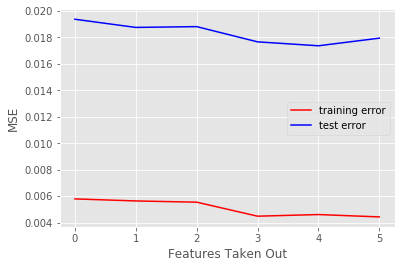

In [24]:
plt.figure()
plt.plot(np.array(recursive_forest_score)*-1,c='red', label='training error')
plt.plot(np.array(recursive_forest_test_score)*-1,c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Features Taken Out')
plt.legend()
plt.show()


In [25]:
# # Recursive forest
# recursive_forest_score=[]
# recursive_forest_test_score=[]
# i=0
# forest_df=trainX.copy()
# forest_df_test=testX.copy()
# for col in forest_best_feat[-1:-101:-1]:
#     i+=1
#     forest_df.drop(col,axis=1,inplace=True)
#     forest_df_test.drop(col,axis=1,inplace=True)
#     recursive_f_para_search=GridSearchCV(ensemble.RandomForestRegressor(n_estimators=100,criterion="mse",\
#                                                                  min_samples_leaf=2,min_samples_split=2,\
#                                                                  bootstrap=True,oob_score = True,n_jobs=-1),\
#                                   param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,refit=True)
#     recursive_f_para_search.fit(forest_df,trainY)
#     recursive_forest_score.append(recursive_f_para_search.score(forest_df,trainY))
#     recursive_forest_test_score.append(recursive_f_para_search.score(forest_df_test,testY))
#     print(i,'/',np.array(forest_best_feat[-1:-101:-1]).shape[0],end='\r')

In [45]:
########################################################
########################################################
######## Predict Kaggle ################################
# we see that mse begins rise up
forest_df=pd.concat([trainX.copy(),testX.copy()],axis=0,sort=False)
totalY=pd.concat([trainY,testY],axis=0,sort=False)

recursive_f_para_search.fit(forest_df[forest_best_feat[:-30*5]],totalY)
forest_predict_for_test=recursive_f_para_search.predict(forest_df[forest_best_feat[:-30*5]]) # <----- for ensemble coefficient optimization
forest_predict=recursive_f_para_search.predict(kaggle_test[forest_best_feat[:-30*5]])
######## Predict Kaggle ################################
########################################################
########################################################

### Gradient Boost

In [27]:
# Initial Boost
boost_param_grid = {'learning_rate': np.linspace(0.05,0.3,6), 'max_depth': range(3,8),'min_samples_split': range(2,8)}
grid_search_boost = GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100,max_features='sqrt',min_samples_leaf=5,random_state=0), param_grid = boost_param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
%time grid_search_boost.fit(trainX, trainY)
# Print results    
print('MSE Score on test data set (using best parameters): {0:.3f}'.format(-grid_search_boost.score(testX, testY)))
print('RMSE in $$ on test data set (using best parameters): {0:.1f}'.format(\
      np.mean((np.exp(grid_search_boost.predict(testX))-np.exp(testY))**2)**0.5))


gbm.set_params(n_estimators=100,learning_rate=grid_search_boost.best_params_['learning_rate'],criterion="mse",random_state=0,\
                   max_depth=grid_search_boost.best_params_['max_depth'],min_samples_split=grid_search_boost.best_params_['min_samples_split'])
gbm.fit(trainX, trainY)
gbm_best_feat=pd.Series(gbm.feature_importances_,index=trainX.columns)
gbm_best_feat.sort_values(ascending=False,inplace=True)
gbm_best_feat=list(gbm_best_feat.index)


CPU times: user 4.43 s, sys: 83.6 ms, total: 4.52 s
Wall time: 33.3 s
MSE Score on test data set (using best parameters): 0.017
RMSE in $$ on test data set (using best parameters): 25443.7


In [28]:
# Recursive gradient boost
recursive_gbm_score=[]
recursive_gbm_test_score=[]
i=0
gbm_df=trainX.copy()
gbm_df_test=testX.copy()
listremoval_gbm=gbm_best_feat.copy()
for reduction in range(7):
    i+=1
    removelist=listremoval_gbm[-30:-1]
    for item in removelist:
        listremoval_gbm.remove(item)
    gbm_df.drop(removelist,axis=1,inplace=True)
    gbm_df_test.drop(removelist,axis=1,inplace=True)
    recursive_gbm_para_search=GridSearchCV(ensemble.GradientBoostingRegressor(n_estimators=100,max_features='sqrt',min_samples_leaf=5,random_state=0), param_grid = boost_param_grid, cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
    recursive_gbm_para_search.fit(gbm_df,trainY)
    recursive_gbm_score.append(recursive_gbm_para_search.score(gbm_df,trainY))
    recursive_gbm_test_score.append(recursive_gbm_para_search.score(gbm_df_test,testY))
    print(i,'/',np.array(gbm_best_feat).shape[0],end='\r')

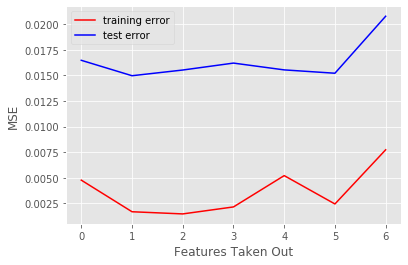

In [29]:
plt.figure()
plt.plot(np.array(recursive_gbm_score)*-1,c='red', label='training error')
plt.plot(np.array(recursive_gbm_test_score)*-1,c='blue', label='test error')
plt.ylabel('MSE')
plt.xlabel('Features Taken Out')
plt.legend()
plt.show()

In [46]:
########################################################
########################################################
######## Predict Kaggle ################################
# we see that mse begins rise up
gbm_df=pd.concat([trainX.copy(),testX.copy()],axis=0,sort=False)
totalY=pd.concat([trainY,testY],axis=0,sort=False)

recursive_gbm_para_search.fit(gbm_df[gbm_best_feat[:-30*2]],totalY)
boost_predict_for_test=recursive_gbm_para_search.predict(gbm_df[gbm_best_feat[:-30*2]]) # <----- for ensemble coefficient optimization
boost_predict=recursive_gbm_para_search.predict(kaggle_test[gbm_best_feat[:-30*2]])
######## Predict Kaggle ################################
########################################################
########################################################

In [47]:
from scipy import optimize

def test_predict_function(x):
    
    y=df[~df.SalePrice.isnull()].SalePrice
    
    return np.sum((np.array(y)-(x[0])*np.array(one_lasso_predict_for_test)-(x[1])*np.array(two_lasso_predict_for_test)-\
(x[2])*np.array(ols_predict_for_test)-(x[3])*np.array(ridge_predict_for_test)-(x[4])*np.array(forest_predict_for_test)-\
(x[5])*np.array(boost_predict_for_test))**2)

coef_results=optimize.minimize(test_predict_function,[1/6,1/6,1/6,1/6,1/6,1/6], method='CG',options={'maxiter':7000})

In [48]:
coef_results

     fun: 15.538395948504007
     jac: array([ 0.00168097, -0.00163949,  0.00297141,  0.00197363, -0.00032318,
        0.00059748])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 7300
     nit: 285
    njev: 911
  status: 2
 success: False
       x: array([ 0.0190249 ,  0.98317255,  0.01801668, -0.01553143,  0.03063585,
       -0.03532144])

In [49]:
final_predict=(coef_results.x[0])*np.array(one_lasso_predict)+(coef_results.x[1])*np.array(two_lasso_predict)+\
(coef_results.x[2])*np.array(ols_predict)+(coef_results.x[3])*np.array(ridge_predict)+(coef_results.x[4])*np.array(forest_predict)+\
(coef_results.x[5])*np.array(boost_predict)
final_predict

array([11.64790375, 11.94332812, 12.06424497, ..., 11.97407068,
       11.7429404 , 12.33821859])

In [50]:
submission = pd.DataFrame()
submission['Id'] = df_test.index
submission['SalePrice'] = np.exp(final_predict)
submission.to_csv('AAAG_F_v2.csv',index=False)